[1.  Data Washing :) :)](#dw)
2. [Time Difference btw Adverse Event Start Date & CAERS Created Date] (#tdiff)
3. [Number of Adverse Event & CAERS Report Created From [2000 - 2016]] (numb)
4. Gender Distribution by Age Group (#gen)
5.  Heatmap Btw Day of Week & Months(#ht)
6. Age Group Distribution by Death Outcomes and (Potential) Death Symptoms(#age)
7. Top 10 Frequents Symptoms by Age Group(#t10a)
8. Top 10 Frequents Outcomes by Age Group(#10b)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
%matplotlib inline
from matplotlib import cm
sns.set_style('ticks')
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('CAERS_ASCII_2004_2017Q2.csv')
df.head(2)

,RA_Report #,RA_CAERS Created Date,AEC_Event Start Date,PRI_Product Role,PRI_Reported Brand/Product Name,PRI_FDA Industry Code,PRI_FDA Industry Name,CI_Age at Adverse Event,CI_Age Unit,CI_Gender,AEC_One Row Outcomes,SYM_One Row Coded Symptoms
0,65325,1/1/2004,8/4/2003,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,3,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, RASH, WHEEZING, COUGH, HOSPITAL..."
1,65325,1/1/2004,8/4/2003,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,3,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, WHEEZING, COUGH, RASH, HOSPITAL..."


In [3]:
(df.isnull().sum()/df.shape[0])*100

RA_Report #                         0.000000
RA_CAERS Created Date               0.000000
AEC_Event Start Date               40.901681
PRI_Product Role                    0.000000
PRI_Reported Brand/Product Name     0.000000
PRI_FDA Industry Code               0.000000
PRI_FDA Industry Name               0.000000
CI_Age at Adverse Event            41.702465
CI_Age Unit                         0.000000
CI_Gender                           0.000000
AEC_One Row Outcomes                0.000000
SYM_One Row Coded Symptoms          0.005507
dtype: float64

In [4]:
#Split the columns name at (_) and lower case all the word in columns
df.columns = [df.columns[x].split('_')[1].lower() for x in range(len(df.columns))]
df.columns = df.columns.str.replace (' #', '_id')

In [5]:
df.columns = ['report_id', 'caers created date', 'event start date', 'product role',
       'product name', 'industry code', 'industry name',
       'age at adverse event', 'age unit', 'gender', 'outcomes',
       'symptoms']

Every Report_ID aka RA_Report # is associated to a single case. but a case can have more than two different PRI_FDA Industry Name or PRI_Reported Brand/Product Name associated to it. The symptoms and the outcomes are the same per Report_ID. Therefore we will drop any duplicated Report ID for the first part of the analysis

In [6]:
df.shape

(90786, 12)

In [7]:
df_no_duplicate = df
#Dropping all duplicate rows but keeping the first row
df_no_duplicate.drop_duplicates(subset='report_id',inplace=True)

After removing all duplicated report ID, I want to know what it the time difference between the time a adverse started and the time it was reported. To do so, I 
    1. converted the ['caers created date'] and ['event start date'] from string to datetime format
    2. Computed the time Difference Between the Event Start Date and the CAERS Created Date
    3. Grouped the Time difference by different periods such as['less than 6 Months','less than 1 year','1 to 3 years','3 to 5 years','5 to 10 Years'] 
    4. Replaced 'nan' value with Unkonwn

In [8]:
## Convert df_no_duplicate['caers created date'] and df_no_duplicate ['event start date'] to datetime format
df_no_duplicate['caers created date'] = pd.to_datetime(df_no_duplicate['caers created date'])
df_no_duplicate['event start date'] = pd.to_datetime(df_no_duplicate['event start date'])

# Compute the time Difference Between the Event Start Date and the CAERS Created Date
df_no_duplicate['time_diff'] = (df_no_duplicate['caers created date'] - df_no_duplicate['event start date']).dt.days

# Group the Time difference by different periods
time_list = (0,180,366,1098,1830,3660)
time_cat = ['less than 6 Months','less than 1 year','1 to 3 years','3 to 5 years','5 to 10 Years']
df_no_duplicate['time_group'] = pd.cut(df_no_duplicate['time_diff'],time_list,labels= time_cat)

df_no_duplicate['time_group'] = df_no_duplicate['time_group'].astype('str')

df_no_duplicate['time_group'] = df_no_duplicate['time_group'].replace('nan','Unknown')

Similar to the work done above, I
    1. Removed all the row with ['age unit'] = 'Not Available' for the dataset
    2. converted the age unit to week  so that the will be only one unit for each age
    3. Multipled the age unit (in week) by the [age at adverse event]
    4. Grouped the result in to age category such as ['Newborn','Infant','Toddler','Preschooler','Child','Adolescent','Young Adult','Adult','Elderly']

In [9]:
## Let Split the data into two dataset...one that has age unit and one that don't('Not Available' as value)
data_age = df_no_duplicate[df_no_duplicate['age unit']!= 'Not Available']

# Convert the age unit to week, which means year = 52 week, month= 4 weeks, day = 1/7 ~= 0.143 week, decade = 520 weeks
age_change = {'Year(s)':52,'Month(s)':4,'Week(s)':1,'Day(s)':0.143,'Decade(s)':520}
data_age['age_by_week'] = df['age unit'].map(age_change)

#Multiply the age at adverse by age_by_week to have Age in a single unit which is weeks
data_age['age_in_week'] = data_age['age at adverse event'] * data_age['age_by_week']

In [10]:
# Generate a new column that will break down the age_in_week by category
age_list = (0,6,52,156,260,624,936,2080,3380,5200)
#The numbers in age_list are in weeks. We divide a value from age_list by 52, we will have the result in years
age_cat = ['Newborn','Infant','Toddler','Preschooler','Child','Adolescent','Young Adult','Adult','Elderly']
data_age['age_group'] = pd.cut(data_age['age_in_week'],age_list,labels=age_cat)

In [11]:
data_age.head(2)

,report_id,caers created date,event start date,product role,product name,industry code,industry name,age at adverse event,age unit,gender,outcomes,symptoms,time_diff,time_group,age_by_week,age_in_week,age_group
0,65325,2004-01-01,2003-08-04,Suspect,MIDWEST COUNTRY FAIR CHOCOLATE FLAVORED CHIPS,3,Bakery Prod/Dough/Mix/Icing,2.0,Year(s),Female,"VISITED AN ER, VISITED A HEALTH CARE PROVIDER,...","SWELLING FACE, RASH, WHEEZING, COUGH, HOSPITAL...",150.0,less than 6 Months,52.0,104.0,Toddler
3,65335,2004-01-01,2003-11-24,Suspect,ENFAMIL LIPIL BABY FORMULA,40,Baby Food Prod,3.0,Month(s),Not Available,NON-SERIOUS INJURIES/ ILLNESS,"GASTROINTESTINAL DISORDER, VOMITING",38.0,less than 6 Months,4.0,12.0,Infant


## Duration Between the Event Start Date and the CAERS Created Date per Age Group

In [12]:
data_time = data_age[data_age['time_group'] != 'Unknown']
age_index = data_age['age_group'].value_counts().index.tolist()

In [13]:
def value_data (input):
    value_input = data_time[data_time['age_group']== input]['time_group'].value_counts().values.tolist()
    return value_input

In [14]:
def index_data (input):
    index_input = data_time[data_time['age_group']== input]['time_group'].value_counts().index.tolist()
    return index_input

In [15]:
def pie_chart (a,b,c):    
    fig = {
      "data": [
        {
          "values":value_data(a),
          "labels":index_data(a),
          "text":a,
          "textposition":"inside",
          "domain": {"x": [0, .33]},
          "textfont": {'size':12,'color':'white'},  
          "name": a,
          "hoverinfo":"label+percent+name",
          "hole": .4,
          "type": "pie"
        },
        {
          "values": value_data(b),
          "labels": index_data(b),
          "text":b,
          "textposition":"inside",
          "domain": {"x": [.34, .66]},
          "textfont": {'size':12,'color':'white'},
          "name": b,
          "hoverinfo":"label+percent+name",
          "hole": .4,
          "type": "pie"
        },  
        {
          "values": value_data(c),
          "labels": index_data(c),
          "text":c,
          "textposition":"inside",
          "domain": {"x": [.67, 1]},
          "textfont": {'size':12,'color':'white'},
          "name": c,
          "hoverinfo":"label+percent+name",
          "hole": .4,
          "type": "pie"
        }],
      "layout": {
            "title":"Duration Between Adverse Event Start Date & CAERS Created Date",
            "annotations": [
                {
                    "font": {
                        "size": 20
                    },
                    "showarrow": False,
                    "text": a,
                    "x": 0.12,
                    "y": 0.5
                },
                {
                    "font": {
                        "size": 20
                    },
                    "showarrow": False,
                    "text": b,
                    "x": 0.5,
                    "y": 0.5
                },
                {
                    "font": {
                        "size": 20
                    },
                    "showarrow": False,
                    "text": c,
                    "x": 0.9,
                    "y": 0.5
                }
            ]
        }
    }
    return py.iplot(fig)

In [16]:
pie_chart(age_index[0],age_index[1],age_index[2]) # Pie chart for ['Adult','Elderly','Young Adult']
pie_chart(age_index[3],age_index[4],age_index[5]) # Pie chart for ['Child','Adolescent','Infant]
pie_chart(age_index[6],age_index[7],age_index[8]) # Pie chart for [Toddler','Preschooler','Newborn']

For each Age group, the analysis show that over 80% of adverse cases were created by the CAERS within 6 months after the adverse started.

In [17]:
data_age['year_start'] = data_age['event start date'].apply(lambda x: x.year)
data_age['year_reported'] = data_age['caers created date'].apply(lambda x: x.year)

In [18]:
x1= data_age['year_start'].value_counts().sort_index().index 
y1= data_age['year_start'].value_counts().sort_index().values 

x2= data_age['year_reported'].value_counts().sort_index().index 
y2= data_age['year_reported'].value_counts().sort_index().values 

trace1 = go.Scatter(
    x=x1,
    y=y1,
    mode = 'lines+markers',
    marker=dict(
    color='red'),
    name = 'Event start',
    
)
trace2 = go.Scatter(
    x=x2,
    y=y2,
    mode = 'lines+markers',
    marker=dict(
    color='blue'),
    name = 'Event Reported',
    
)
data = [trace1,trace2]
layout = go.Layout(
    
    xaxis=dict(
        title = 'Years',
        range = [1999.9,2016.02],
        autotick=True,
        
    ),
    
    xaxis2=dict(
        range = [1999.9,2016.02],
        autotick=True
    ),
    yaxis = dict(
    title = 'Frequency'
    ),
    
    title = 'Adverse Event Start Date & CAERS Created Date From [2000 - 2016]'
    )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


## Gender Distribution by Age Group

In [19]:
gender = ['Male','Female']
data_gender = data_age[data_age['gender'].isin (gender)]

In [20]:
def value_data_2 (input):
    value_input = data_gender[data_gender['age_group']== input]['gender'].value_counts().values.tolist()
    return value_input

In [21]:
def index_data_2 (input):
    index_input = data_gender[data_gender['age_group']== input]['gender'].value_counts().index.tolist()
    return index_input

In [22]:
def pie_chart (a,b,c):    
    fig = {
      "data": [
        {
          "values":value_data_2(a),
          "labels":index_data_2(a),
          "text":a,
          "textposition":"inside",
          "domain": {"x": [0, .33]},
          "textfont": {'size':12,'color':'white'},  
          "name": a,
          "hoverinfo":"label+percent+name",
          "hole": .4,
          "type": "pie"
        },
        {
          "values": value_data_2(b),
          "labels": index_data_2(b),
          "text":b,
          "textposition":"inside",
          "domain": {"x": [.34, .66]},
          "textfont": {'size':12,'color':'white'},
          "name": b,
          "hoverinfo":"label+percent+name",
          "hole": .4,
          "type": "pie"
        },  
        {
          "values": value_data_2(c),
          "labels": index_data_2(c),
          "text":c,
          "textposition":"inside",
          "domain": {"x": [.67, 1]},
          "textfont": {'size':12,'color':'white'},
          "name": c,
          "hoverinfo":"label+percent+name",
          "hole": .4,
          "type": "pie"
        }],
      "layout": {
            "title":"Gender Distribution by Age Group",
            "annotations": [
                {
                    "font": {
                        "size": 20
                    },
                    "showarrow": False,
                    "text": a,
                    "x": 0.12,
                    "y": 0.5
                },
                {
                    "font": {
                        "size": 20
                    },
                    "showarrow": False,
                    "text": b,
                    "x": 0.5,
                    "y": 0.5
                },
                {
                    "font": {
                        "size": 20
                    },
                    "showarrow": False,
                    "text": c,
                    "x": 0.9,
                    "y": 0.5
                }
            ]
        }
    }
    return py.iplot(fig)

In [23]:
pie_chart(age_index[0],age_index[1],age_index[2]) # Pie chart for ['Adult','Elderly','Young Adult']
pie_chart(age_index[3],age_index[4],age_index[5]) # Pie chart for ['Child','Adolescent','Infant]
pie_chart(age_index[6],age_index[7],age_index[8]) # Pie chart for [Toddler','Preschooler','Newborn']

## Heatmap Between Day of Week & Months 

In [24]:
from pandas.api.types import CategoricalDtype

In [25]:
def date_extract (input,cmap):
    data_age['month']= data_age[input].apply(lambda x: x.month) #this will extract Month from the event_date format
    data_age['day of week']= data_age[input].apply(lambda x: x.dayofweek)

    # Extracting Month from the event start date
    dmonth = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',
             9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    data_age['month'] = data_age['month'].map(dmonth)
    #Categorizing the month from the normal order
    cat_type = CategoricalDtype(categories=['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 'Jul', 
                                            'Aug','Sep', 'Oct', 'Nov', 'Dec'],ordered=True)
    data_age['month'] = data_age['month'].astype(cat_type)

    # Extracting Day of Week from the event start date
    dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
    cat_type_2 = CategoricalDtype(categories=['Mon', 'Tue', 'Wed', 'Thu','Fri','Sat', 'Sun'],ordered=True)

    data_age['day of week']= data_age['day of week'].map(dmap)
    data_age['day of week'] = data_age['day of week'].astype(cat_type_2)
    
    ## Plot the heatmap of day of week and month
    event_timeline = data_age.groupby(['day of week','month']).count()['report_id'].unstack()

    grid_kws = {"height_ratios": (.9, .05), "hspace": .3}

    f, (ax, cbar_ax) = plt.subplots(2,gridspec_kw=grid_kws, figsize=(15,10))

    ax = sns.heatmap(event_timeline, cmap=cmap,linecolor='white',linewidths=1,annot=True,fmt='.1f',
                    ax=ax, cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"}, annot_kws={'fontsize':13})
    ax.tick_params(length=3, width=1, colors='black',labelsize='large')
    kwargs= {'fontsize':13, 'color':'black'}
    ax.set_xlabel('Months',**kwargs)
    ax.set_ylabel('Day of Week',**kwargs)
    ax.set_title('Weekly '+ input + ' per Month',fontdict={'fontsize':20, 'color':'black'})
    
    return plt.show()

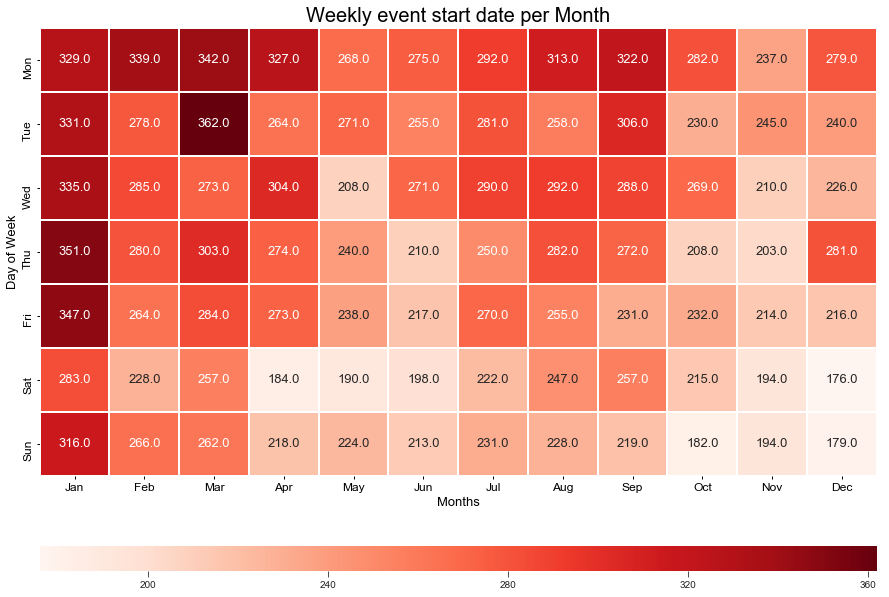

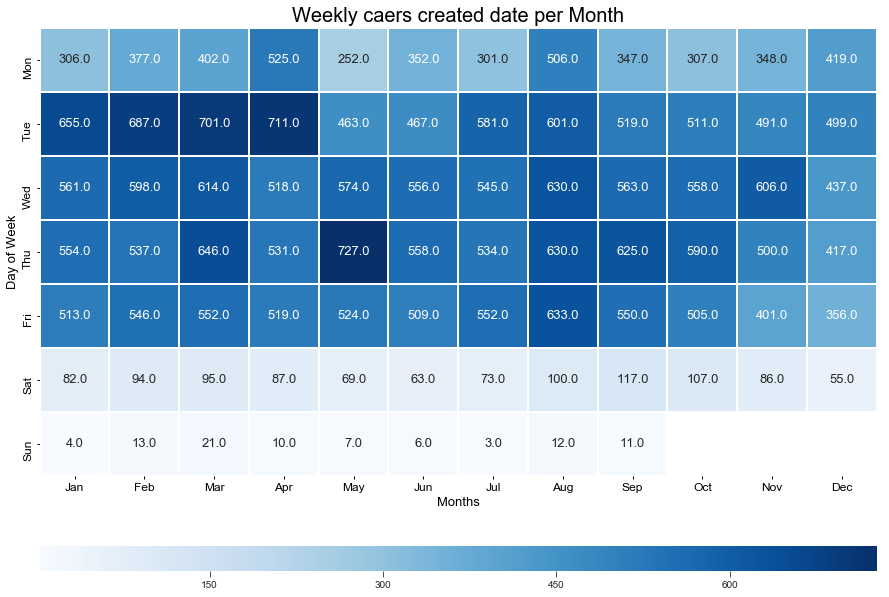

In [26]:
# Event Start Date
date_extract('event start date','Reds')
# caers created date
date_extract('caers created date','Blues')


## Age Group Distribution by Death Outcomes and (Potential) Death Symptoms

In [27]:
death_data = data_age.dropna(subset=['outcomes'])
##death outcomes
dd = death_data[death_data['outcomes'].str.contains('DEATH')]['age_group'].value_counts()
death_x = dd.index.tolist()
death_y = dd.values.tolist()
## Potential Death Symptoms
symp_data = data_age.dropna(subset=['symptoms'])
sd = symp_data[symp_data['symptoms'].str.contains('DEATH')]['age_group'].value_counts()
sd_x = sd.index.tolist()
sd_y = sd.values.tolist()

In [28]:
# Age Group data
age_index = data_age['age_group'].value_counts().index.tolist()
age_value = data_age['age_group'].value_counts().values.tolist()

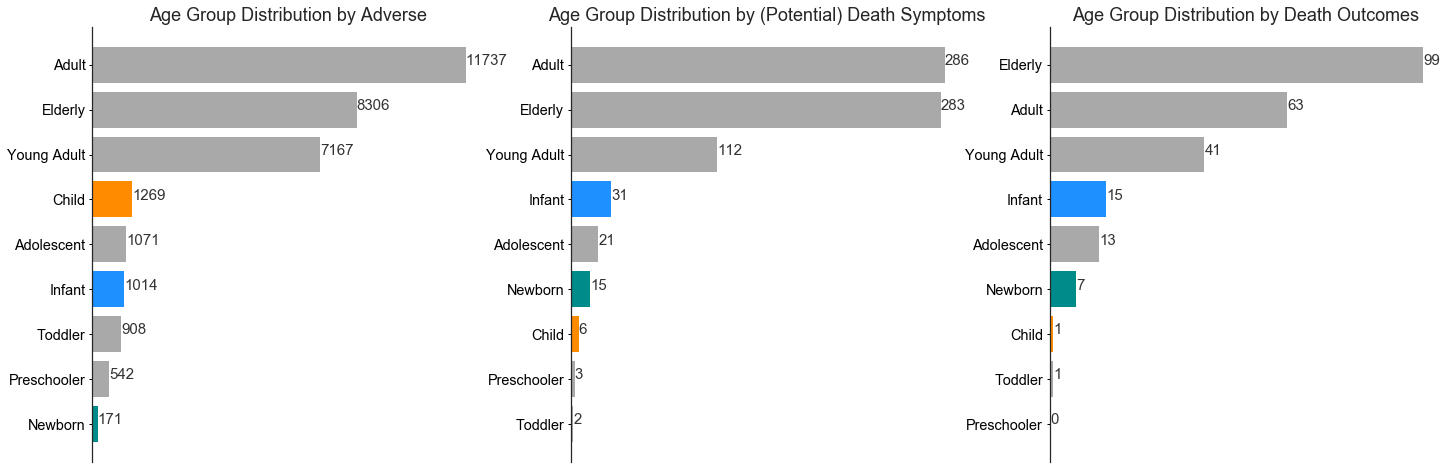

In [29]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,8))
color1 = ["darkgray","darkgray","darkgray",'DarkOrange',"darkgray",'dodgerblue',"darkgray","darkgray","DarkCyan"]
color2 = ["darkgray","darkgray","darkgray",'dodgerblue',"darkgray","DarkCyan",'DarkOrange',"darkgray","darkgray"]

ax1.barh(age_index,age_value,color=color1)
ax2.barh(death_x,death_y,color=color2)
ax3.barh(sd_x,sd_y,color=color2)

title = ["Age Group Distribution by Adverse","Age Group Distribution by (Potential) Death Symptoms",
      "Age Group Distribution by Death Outcomes"]
# set individual bar lables using above list
axes = [ax1,ax2,ax3]

for j in range(len(axes)):
    for i in axes[j].patches:
    # get_width pulls left or right; get_y pushes up or down
        axes[j].text(i.get_width()+.1, i.get_y()+.40, \
            str(round((i.get_width()), 2)), fontsize=15, color='black',alpha=0.8)  
# invert for largest on top 
    axes[j].invert_yaxis()
    # Set Title
    
    axes[j].set_title(title[j], fontsize=18)
    
    #Set Axis
    kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'x-large'}
    axes[j].tick_params(**kwargs)
    x_axis = axes[j].axes.get_xaxis().set_visible(False)
    
    f.subplots_adjust(wspace=0.22,right=2,hspace=0.4)
    sns.despine(bottom=True)

From the graph above, we observed that the top 3 age group ('Adult','Elderly','Young Adult') by Adverse cases have the highest Death outcomes and have suffered from potential death Symptoms.
The interesting observation is the 'Child' group which is 4th in the number of adverse cases but drop 7th in death outcomes and potential death Symptoms. This is not the case for Infant and Newborn group which have an increase in  ranking in the death outcomes and potential death Symptoms

In [30]:
age_index

['Adult',
 'Elderly',
 'Young Adult',
 'Child',
 'Adolescent',
 'Infant',
 'Toddler',
 'Preschooler',
 'Newborn']

In [31]:
import random
ra_label = [random.choice(range(10)) for i in range(len(age_index))]

In [32]:
ra_label

[0, 9, 0, 5, 7, 8, 1, 6, 2]

## Top 10 Frequents Symptoms by Age Group 

In [33]:
def symptom_count (age_group):
    ex = data_age[data_age['age_group']== age_group]#['symptoms'].astype(object).str.split(",").iteritems()
    word_count = []
    for i, word in ex['symptoms'].replace(' ',"").astype(object).str.split(",").iteritems():
        word_count += [str(w).strip().title().lower() for w in pd.Series(word).astype(object)]
    return pd.Series(word_count).value_counts().head(10)

In [34]:
def func_age (a,b,c):    
    f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,8))
    a_symtom = symptom_count(a)
    b_symtom = symptom_count(b)
    c_symtom = symptom_count(c)
    #Color
    color = ["DarkOrange","DarkOrange","DarkOrange","darkgray","darkgray","darkgray","darkgray",
              "darkgray","darkgray","darkgray"]
    #Graph formula
    ax1.barh(a_symtom.index,a_symtom.values,color=color)
    ax2.barh(b_symtom.index,b_symtom.values,color=color)
    ax3.barh(c_symtom.index,c_symtom.values,color=color)

    # set individual bar lables using above list
    axes = [ax1,ax2,ax3]

    for j in range(len(axes)):
        for i in axes[j].patches:
        # get_width pulls left or right; get_y pushes up or down
            axes[j].text(i.get_width()+.12, i.get_y()+.38, \
                str(round((i.get_width()), 2)), fontsize=15, color='black',alpha=0.8)  
    
    # invert for largest on top 
        axes[j].invert_yaxis()
        #Set Axis
        kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'x-large'}
        axes[j].tick_params(**kwargs)
        x_axis = axes[j].axes.get_xaxis().set_visible(False)
        f.subplots_adjust(wspace=0.22,right=2,hspace=0.4)
        sns.despine(bottom=True)
        # Set Title
        k = [a,b,c]
        axes[j].set_title("Top 10 Symptoms on "+ k[j], fontsize=25, color ='black')
    return plt.show()

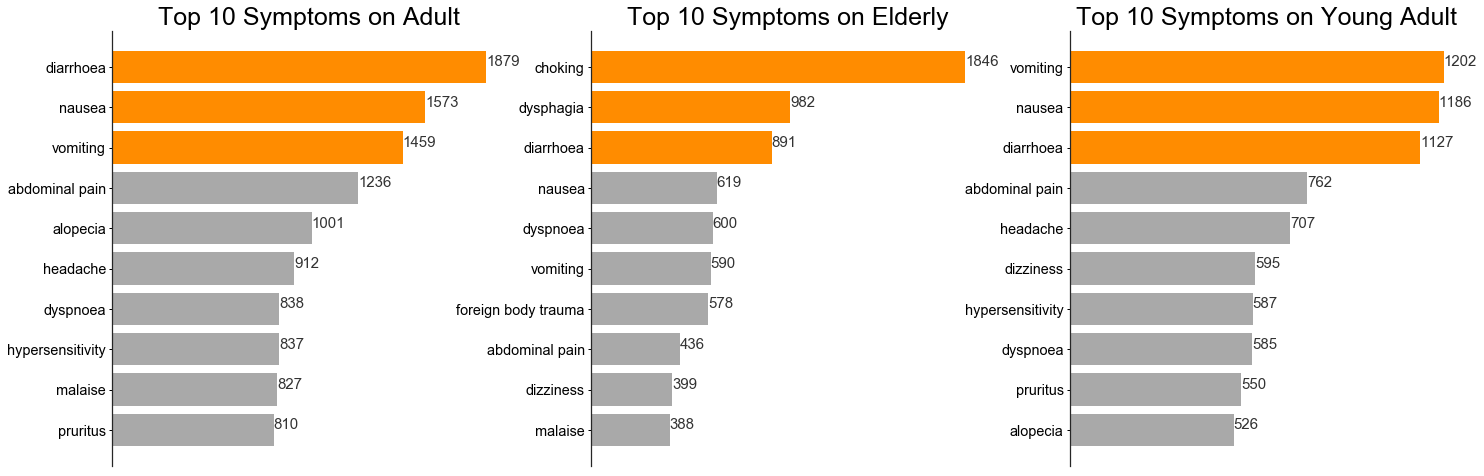

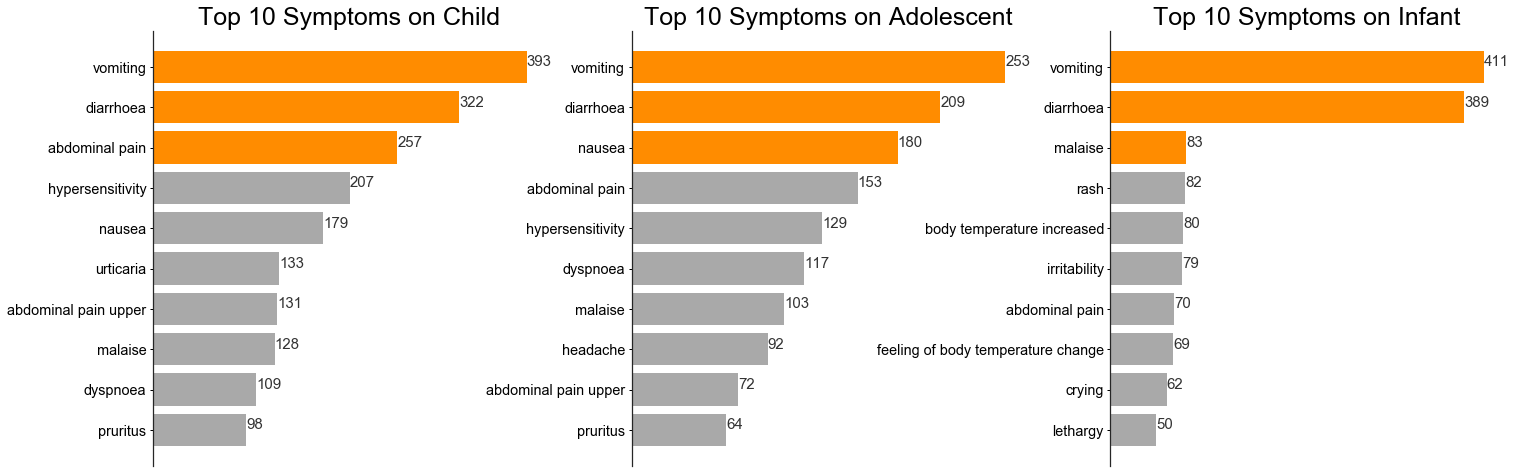

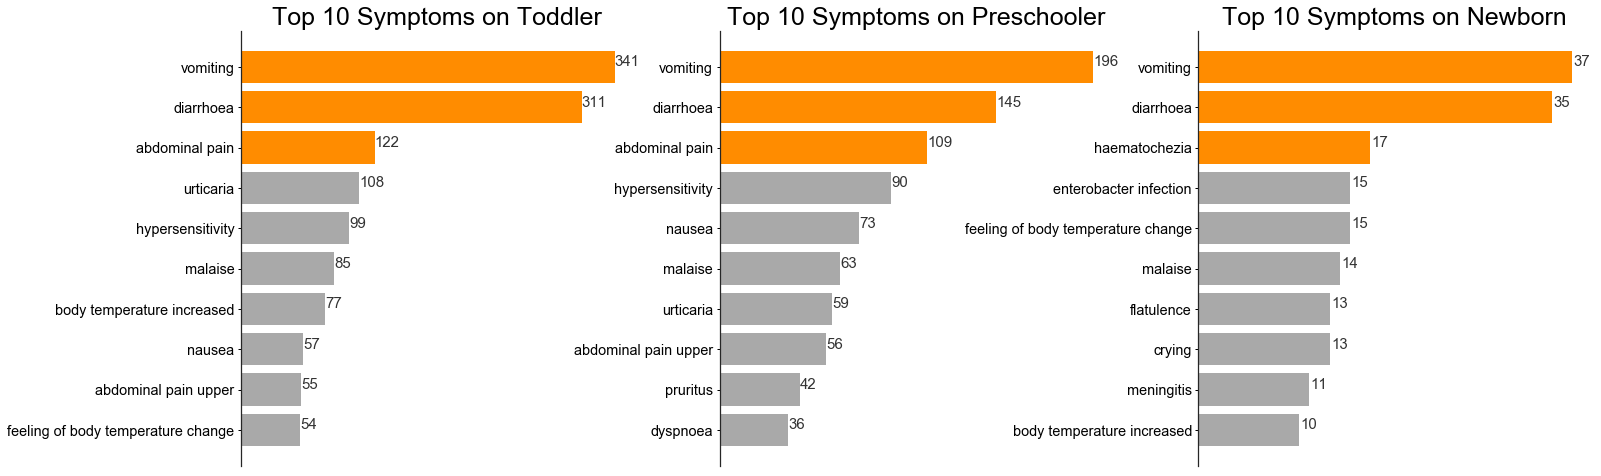

In [35]:
func_age(age_index[0],age_index[1],age_index[2]) # bar Plot for ['Adult','Elderly','Young Adult']

func_age(age_index[3],age_index[4],age_index[5]) # bar plot for ['Child','Adolescent','Infant]

func_age(age_index[6],age_index[7],age_index[8]) # bar plot for [Toddler','Preschooler','Newborn']

Vomiting, Diarrhoea and Abdominal Pain are the frequent symptoms observed in all the Age group